# Installing the required libraries

In [ ]:
pip install kaggle

In [ ]:
!pip install byol-pytorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.9 MB/s eta 0:00:00


In [ ]:
!pip install einops -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 737.1 kB/s eta 0:00:00


# Downloading the data for Brain Tumor Images



## Steps followed
1. Downloading the data from kaggle
2. Unzipping the data from the zip file in quiet mode using the `-q` parameter
3. Putting the data in a folder called Data

In [ ]:
# !kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

In [ ]:
# Unizipping the files in a folder called data
# !unzip -q /content/breast-ultrasound-images-dataset.zip -d /content/data #unzips the file in a folder called data

In [ ]:
# !kaggle datasets download -d prathamgrover/3d-liver-segmentation

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 60% 9.00M/15.1M [00:00<00:00, 69.2MB/s]
100% 15.1M/15.1M [00:00<00:00, 102MB/s] 


In [ ]:
# Unizipping the files in a folder called data
!unzip -q /content/brain-mri-images-for-brain-tumor-detection.zip -d /content/data

In [ ]:
# !unzip -q /content/3d-liver-segmentation.zip -d /content/data

## Importing the required Libraries

In [ ]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from einops import rearrange
from byol_pytorch import BYOL
from torchvision import models

### Setting up the device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Creating the dataloader
Here we are taking the whole dataset and converting them together into a single dataset as we want to do a self-supervised learning. Thus we are joining both the data points with brain tumor and without brain tumor.

In [ ]:
os.chdir('/content/data/yes')
X = []
y = []
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(128,128))
      X.append(img)
      y.append(1)
os.chdir('/content/data/no')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(128,128))
      X.append(img)
for i in range(1,99):
    y.append(0)

100%|██████████| 98/98 [00:00<00:00, 249.85it/s]


### Now we convert the data from a list -> Numpy -> tensors

In [ ]:
X_tensor = torch.from_numpy(np.array(X)).type(torch.float)
y_tensor = torch.from_numpy(np.array(y)).type(torch.float)

In [ ]:
# rearrange elements according to the pattern
X_tensor = rearrange(X_tensor, 's h b c -> s c h b')
X_tensor.shape

torch.Size([253, 3, 128, 128])

# Dividing data for the selfsupervision task and for the downstream task

In [ ]:
#Dividing the data into a 60-40 split, one part for the self supervision task and another part for the downstream training part
X_unsupervised, X_downstream, y_unsupervised, y_downstream = train_test_split(X_tensor, y_tensor, test_size=0.4, random_state=42)

In [ ]:
len(X_unsupervised), len(X_downstream), len(y_unsupervised), len(y_downstream)
#We will use this 151 images for self supervision and then use the 102 for training and testing the downstream


(151, 102, 151, 102)

In [ ]:
len(X), len(y) # Checking the no of data points

(253, 253)

In [ ]:
X_tensor.dtype, y_tensor.dtype #Checking if the data type is accurate

(torch.float32, torch.float32)

In [ ]:
X_tensor[1].shape # Checking the shape of the tensor, which would be neded for training

torch.Size([3, 128, 128])

# Here we are visualizing the data

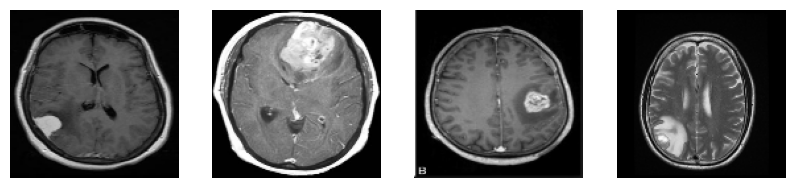

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
X[1].shape # We see here that the data is of the shape (256,256, 3)

(128, 128, 3)

In [ ]:
y_tensor.shape

torch.Size([253])

In [ ]:
X_unsupervised = X_unsupervised.to(device)
y_unsupervised = y_unsupervised.to(device) #putting the data on cuda for faster training

In [ ]:
# X_train.shape

# BYOL model training
I am using the BYOL over SimCLR as BYOL (Bootstrap Your Own Latent) offers several advantages over SimCLR (Simple Framework for Contrastive Learning of Visual Representations):

### **No Negative Pairs**
- **SimCLR**: Relies on the concept of contrastive learning with negative pairs. It requires large batch sizes to ensure a diverse set of negative examples, which helps in pulling together representations of similar images while pushing apart representations of dissimilar images.
- **BYOL**: Does not use negative pairs. Instead, it focuses on learning by predicting the representations of different augmented views of the same image.
- **Advantage**: By eliminating the need for negative pairs, BYOL simplifies the learning process and reduces the dependency on large batch sizes, making it more efficient and accessible, especially for users with limited computational resources.


___

# Resources

Paper link - https://arxiv.org/abs/2006.07733

Thanks to <a href=https://github.com/lucidrains>Phil Wang</a> for providng the torch implementation of BYOL

Torch implementation of BYOL - https://github.com/lucidrains/byol-pytorch

Also thanks to <a href=https://www.youtube.com/@YannicKilcher>Yannic Kilcher</a>, for the excellent explanation of the BYOL paper

Youtube Explanation - https://www.youtube.com/watch?v=YPfUiOMYOEE




In [ ]:
resnet = models.resnet50(pretrained=True)

learner = BYOL(
    resnet,
    image_size = 128,
    hidden_layer = 'avgpool'
).to(device)

opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

for _ in tqdm(range(100)):
    images = X_unsupervised
    loss = learner(images)
    opt.zero_grad()
    loss.backward()
    opt.step()
    learner.update_moving_average() # update moving average of target encoder

# save your improved network
# torch.save(resnet.state_dict(), './improved-net.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 47.0MB/s]
  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRI

In [ ]:
torch.save(resnet.state_dict(), '/content/improved-net.pth') # saving the network weights

In [ ]:
# X_test[3].shape

In [ ]:
output = learner(torch.randn((2,3,32,32)).to(device))

In [ ]:
output

tensor(3.3012, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
learner.online_encoder #checking the architecture of the online encoder in BYOL

NetWrapper(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
c =learner.online_encoder((torch.randn((26, 3,128, 128)).to(device)))
c[0].shape

torch.Size([26, 256])

In [ ]:
# X_test.shape

In [ ]:
# c = learner.online_encoder(X_test)

In [ ]:
# c[0].shape

# Dividing the Data in Train test split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_downstream, y_downstream, test_size=0.1, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(91, 11, 91, 11)

In [ ]:
# Converting the data from cpu to cuda for faster performance
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

<ipython-input-37-e0a1c6b8537c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
<ipython-input-37-e0a1c6b8537c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).to(device)


## Building the Downstream Model

### Step 1: Extracting the Online Encoder for Feature Extraction
First, we will extract the online encoder from the trained BYOL model. The online encoder is responsible for performing feature extraction on the input data.

### Step 2: Setting the Trainable Parameters to False
Next, we will freeze the parameters of the online encoder by setting `requires_grad` to `False`. This ensures that the encoder’s weights are not updated during the training of the downstream task.

### Step 3: Building the Downstream Task for Classification
At the end we will build the downstream task for classification by adding a classification head on top of the frozen encoder by adding one layer to transform the extracted features into the desired output classes.

### Step 4: Training the Downstream Model for Classifiation
Then we write the training loop and try to minimise the loss and calculate the accuracy of the model

In [ ]:
class DownstreamModel(nn.Module):
    def __init__(self):
        super(DownstreamModel, self).__init__()
        self.encoder = learner.online_encoder
        self.encoder.requires_grad_(False)
        self.projection = nn.Linear(256, 1) # Here we are adding a layer to convert the output from the online-encoder of BYOL into our classification example

    def forward(self, x):
        x = self.encoder(x)[0]
        x = self.projection(x)
        return x

In [ ]:
torch.cuda.manual_seed(42)
model = DownstreamModel().to(device) # calling the model
model

DownstreamModel(
  (encoder): NetWrapper(
    (net): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [ ]:
output = model(X_test)

In [ ]:
model.eval() #dry running the model before any training
with torch.inference_mode():
    y_logit = model(X_test)
    y_pred = torch.round(torch.sigmoid(y_logit))

y_pred

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def accuracy(y_true, y_pred): #for calculating the accuracy
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
print(accuracy(y_test, y_pred.squeeze(1))) #Here we see that the accuracy is really bad with random weights

36.36363636363637


In [ ]:
y_train.float()

tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1.], device='cuda:0')

# Training the Downstream model

In [ ]:
epochs = 1000
loss_arr = []

for epoch in tqdm(range(epochs)):
    model.train()
    y_logit = model(X_train).squeeze(1)
    loss = loss_fn(y_logit, y_train.float())
    loss_arr.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

  0%|          | 1/1000 [00:00<01:57,  8.48it/s]

Epoch 1/1000, Loss: 1.1053


 10%|█         | 102/1000 [00:11<01:38,  9.11it/s]

Epoch 101/1000, Loss: 0.5089


 20%|██        | 202/1000 [00:22<01:27,  9.13it/s]

Epoch 201/1000, Loss: 0.4462


 30%|███       | 302/1000 [00:33<01:17,  8.98it/s]

Epoch 301/1000, Loss: 0.3973


 40%|████      | 402/1000 [00:44<01:07,  8.89it/s]

Epoch 401/1000, Loss: 0.3621


 50%|█████     | 502/1000 [00:55<00:55,  9.03it/s]

Epoch 501/1000, Loss: 0.3361


 60%|██████    | 602/1000 [01:06<00:44,  9.04it/s]

Epoch 601/1000, Loss: 0.3160


 70%|███████   | 702/1000 [01:17<00:33,  9.02it/s]

Epoch 701/1000, Loss: 0.2994


 80%|████████  | 802/1000 [01:29<00:21,  9.05it/s]

Epoch 801/1000, Loss: 0.2854


 90%|█████████ | 902/1000 [01:40<00:10,  9.01it/s]

Epoch 901/1000, Loss: 0.2730


100%|██████████| 1000/1000 [01:51<00:00,  9.01it/s]


# Visualizing the loss curve

Text(0, 0.5, 'Loss')

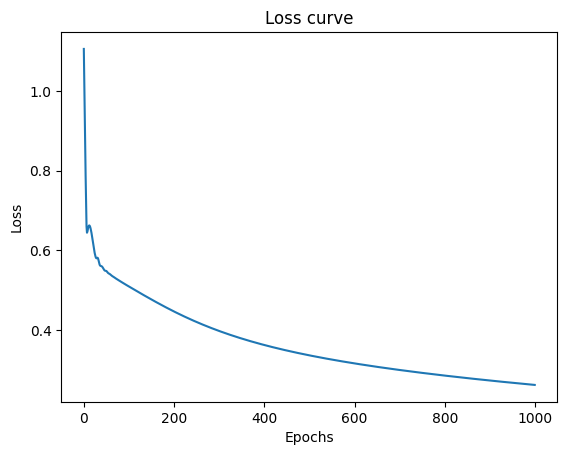

In [ ]:
plt.plot(loss_arr)
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")


## Calculating Accuracy of the classifiation task

In [ ]:
y_test

tensor([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.], device='cuda:0')

In [ ]:
with torch.inference_mode():
  y_test_logit = model(X_test)
  y_test_logit.shape
  y_pred = torch.round(torch.sigmoid(y_test_logit))

y_pred.squeeze(1)

tensor([1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.], device='cuda:0')

In [ ]:
print(accuracy(y_test, y_pred.squeeze(1)))

72.72727272727273


# Evaluation

We find that the model returns an accuracy of 72% with this method, as the dataset is small and we only ran 100 epochs of the BYOL model.. this can be improved by more rigorous testing and also the Online trained encoder can be used to build other downstreams tasks like segmentation

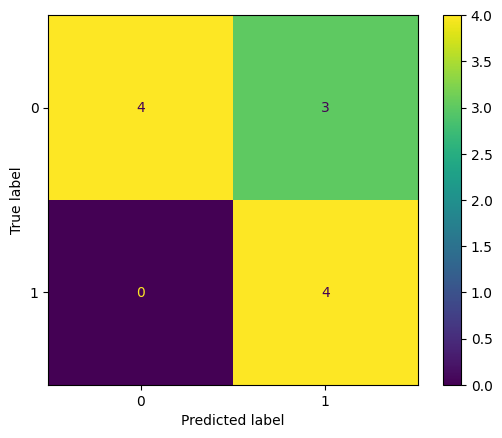

In [ ]:
from sklearn import metrics
y_test = y_test.to('cpu')
y_pred = y_pred.to('cpu')
confusion_matrix = metrics.confusion_matrix(y_test, y_pred.squeeze(1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()


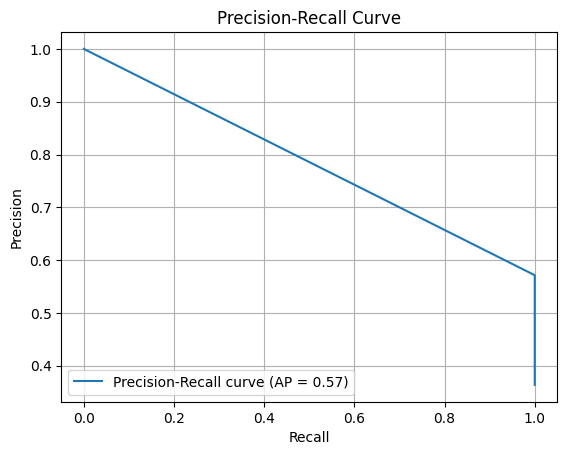

F1 Score: 0.73


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score

y_test_np = y_test.numpy()
y_pred_np = y_pred.squeeze(1).numpy()

precision, recall, thresholds = precision_recall_curve(y_test_np, y_pred_np)

avg_precision = average_precision_score(y_test_np, y_pred_np)

plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Print F1 score
f1 = f1_score(y_test_np, y_pred_np)
print(f'F1 Score: {f1:.2f}')
